# Exploring word vectors

In NLP, we represent each word as a vector consisting of numbers. The vector encodes the meaning of the word. These numbers (or weights) for each word are learned using various machine learning models.Topics covered:

- Predict analogies between words.
- Use PCA to reduce the dimensionality of the word embeddings and plot them in two dimensions.
- Compare word embeddings by using a similarity measure (the cosine similarity).
- Understand how these vector space models work.



## 1. Predict the Countries from Capitals

We will predict the **countries** that corresponds to some **capitals**.


In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import get_vectors

In [4]:
data = pd.read_csv('capitals.txt', delimiter=' ')
data.columns = ['city1', 'country1', 'city2', 'country2']

data.head(5)

,city1,country1,city2,country2
0,Athens,Greece,Bangkok,Thailand
1,Athens,Greece,Beijing,China
2,Athens,Greece,Berlin,Germany
3,Athens,Greece,Bern,Switzerland
4,Athens,Greece,Cairo,Egypt


Now we will load the word embeddings as a Python dictionary

In [5]:
word_embeddings = pickle.load(open("word_embeddings_subset.p", "rb"))
len(word_embeddings) 

243

Each of the word embedding is a 300-dimensional vector.

In [6]:
print("dimension: {}".format(word_embeddings['Spain'].shape[0]))

dimension: 300


### Predict relationships among words


### 1.1 Cosine Similarity

The cosine similarity function is:

$$\cos (\theta)=\frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\|\|\mathbf{B}\|}=\frac{\sum_{i=1}^{n} A_{i} B_{i}}{\sqrt{\sum_{i=1}^{n} A_{i}^{2}} \sqrt{\sum_{i=1}^{n} B_{i}^{2}}}\tag{1}$$

$A$ and $B$ represent the word vectors and $A_i$ or $B_i$ represent index i of that vector.
& Note that if A and B are identical, you will get $cos(\theta) = 1$.
* Otherwise, if they are the total opposite, meaning, $A= -B$, then you would get $cos(\theta) = -1$.
* If you get $cos(\theta) =0$, that means that they are orthogonal (or perpendicular).
* Numbers between 0 and 1 indicate a similarity score.
* Numbers between -1-0 indicate a dissimilarity score.

In [7]:
def cosine_similarity(A, B):
    '''
    Input:
        A: a numpy array which corresponds to a word vector
        B: A numpy array which corresponds to a word vector
    Output:
        cos: numerical number representing the cosine similarity between A and B.
    '''
    dot = np.dot(A, B)
    norma = np.linalg.norm(A)
    normb = np.linalg.norm(B) 
    cos = dot / np.dot(norma, normb)
    return cos

In [9]:
king = word_embeddings['king']
queen = word_embeddings['queen']

cosine_similarity(king, queen)

0.6510957

### 1.2 Euclidean distance

You will now implement a function that computes the similarity between two vectors using the Euclidean distance.
Euclidean distance is defined as:

$$ \begin{aligned} d(\mathbf{A}, \mathbf{B})=d(\mathbf{B}, \mathbf{A}) &=\sqrt{\left(A_{1}-B_{1}\right)^{2}+\left(A_{2}-B_{2}\right)^{2}+\cdots+\left(A_{n}-B_{n}\right)^{2}} \\ &=\sqrt{\sum_{i=1}^{n}\left(A_{i}-B_{i}\right)^{2}} \end{aligned}$$

* $n$ is the number of elements in the vector
* $A$ and $B$ are the corresponding word vectors. 
* The more similar the words, the more likely the Euclidean distance will be close to 0. 


In [10]:
def euclidean(A, B):
    """
    Input:
        A: a numpy array which corresponds to a word vector
        B: A numpy array which corresponds to a word vector
    Output:
        d: numerical number representing the Euclidean distance between A and B.
    """
    d = np.sqrt(np.sum((A-B)**2))
    return d


In [11]:
# Test
euclidean(king, queen)

2.4796925

### 1.3 Finding the country of each capital

Given the following words: 

- 1: Athens 2: Greece 3: Baghdad,

task is to predict the country 4: Iraq.

We can use the analogy of  *King - Man + Woman = Queen* , and implement that scheme into a mathematical function, using the word embeddings and a similarity function.


In [12]:
def get_country(city1, country1, city2, embeddings):
    """
    Input:
        city1: a string (the capital city of country1)
        country1: a string (the country of capital1)
        city2: a string (the capital city of country2)
        embeddings: a dictionary where the keys are words and values are their embeddings
    Output:
        countries: a dictionary with the most likely country and its similarity score
    """
    group = set((city1, country1, city2))
    city1_emb = embeddings[city1]
    country1_emb = embeddings[country1]
    city2_emb = embeddings[city2]

    # King - Man + Woman = Queen
    vec = country1_emb - city1_emb + city2_emb 

    similarity = -1
    country = ''

    # looping through all words in the embeddings dictionary
    for word in embeddings.keys():
        if word not in group:
            word_emb = embeddings[word]
            cur_similarity = cosine_similarity(vec, word_emb)
            if cur_similarity > similarity:
                similarity = cur_similarity
                country = (word, similarity)
                
    return country

In [13]:
# Testing 
get_country('Athens', 'Greece', 'Cairo', word_embeddings)

('Egypt', 0.7626821)

### Model Accuracy

Now you will test your new function on the dataset and check the accuracy of the model:

$$\text{Accuracy}=\frac{\text{Correct # of predictions}}{\text{Total # of predictions}}$$ 

In [14]:
def get_accuracy(word_embeddings, data):
    '''
    Input:
        word_embeddings: a dictionary where the key is a word and the value is its embedding
        data: a pandas dataframe containing all the country and capital city pairs
    
    Output:
        accuracy: the accuracy of the model
    '''
    num_correct = 0

    # loop through the rows of the dataframe
    for i, row in data.iterrows():
        city1 = row['city1']
        country1 = row['country1']
        city2 =  row['city2']
        country2 = row['country2']

        predicted_country2, _ = get_country(city1, country1, city2, word_embeddings)

        if predicted_country2 == country2:
            num_correct += 1

    m = len(data)
    accuracy = num_correct/ m

    return accuracy


In [14]:
accuracy = get_accuracy(word_embeddings, data)

print(f"Accuracy is {accuracy:.2f}")

Accuracy is 0.92


## 2. Plotting the vectors using PCA

Before plotting the words, we first need to reduce each word vector with PCA into 2 dimensions and then plot it. The steps to compute PCA are as follows:

1. Mean normalize the data
2. Compute the covariance matrix of your data ($\Sigma$). 
3. Compute the eigenvectors and the eigenvalues of your covariance matrix
4. Multiply the first K eigenvectors by your normalized data. 

In [15]:
def compute_pca(X, n_components=2):
    """
    Input:
        X: of dimension (m,n) where each row corresponds to a word vector
        n_components: Number of components you want to keep.
    Output:
        X_reduced: data transformed in 2 dims/columns + regenerated original data
    """

    # mean center the data
    X_demeaned = X - np.mean(X, axis=0)
    
    # calculate the covariance matrix
    covariance_matrix = np.cov(X_demeaned, rowvar=False)

    # calculate eigenvectors & eigenvalues of the covariance matrix
    eigen_vals, eigen_vecs = np.linalg.eigh(covariance_matrix)

    # sort eigenvalues in decreasing order
    idx_sorted = np.argsort(eigen_vals)  #returns index
    idx_sorted_decreasing = idx_sorted[::-1]

    # sort the eigen values and eigen vectors by idx_sorted_decreasing
    eigen_vals_sorted = eigen_vals[idx_sorted_decreasing]
    eigen_vecs_sorted = eigen_vecs[:,idx_sorted_decreasing]
    
    # select the first n eigenvectors 
    eigen_vecs_subset = eigen_vecs_sorted[:, :n_components]

    # transform the data by multiplying the transpose of the eigenvectors with the transpose 
    #of the de-meaned data. Then take the transpose of that product.

    X_reduced = (np.dot(eigen_vecs_subset.T, X_demeaned.T)).T

    return X_reduced


In [16]:
# Testing function
np.random.seed(1)
X = np.random.rand(3, 10)
X_reduced = compute_pca(X, n_components=2)
print("original matrix was " + str(X.shape) + " and it became:")
print(X_reduced)

original matrix was (3, 10) and it became:
[[ 0.43437323  0.49820384]
 [ 0.42077249 -0.50351448]
 [-0.85514571  0.00531064]]


In [17]:
words = ['oil', 'gas', 'happy', 'sad', 'city', 'town',
         'village', 'country', 'continent', 'petroleum', 'joyful']

# given a list of words and the embeddings, it returns a matrix with all the embeddings
X = get_vectors(word_embeddings, words)

print('You have 11 words each of 300 dimensions thus X.shape is:', X.shape)

You have 11 words each of 300 dimensions thus X.shape is: (11, 300)


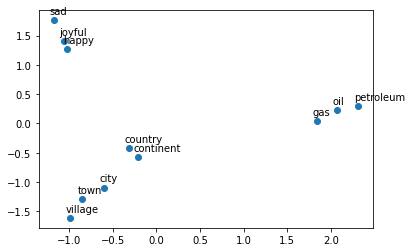

In [18]:
result = compute_pca(X, 2)
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0] - 0.05, result[i, 1] + 0.1))

plt.show()

The word vectors for 'gas', 'oil' and 'petroleum' appear related to each other,
because their vectors are close to each other.  Similarly, 'sad', 'joyful'
and 'happy' all express emotions, and are also near each other.